In [84]:
from tools import *

In [85]:
departement = ['departement-01-ain',
               'departement-25-doubs',
               'departement-69-rhone',
               'departement-78-yvelines'
               ]
root = Path('/home/caron/Bureau/csv')
fp = []

for dept in departement:
    fpp = pd.read_csv(root / dept / 'firepoint' / 'NATURELSfire.csv')
    fpp['departement'] = dept
    fp.append(fpp)

fp = pd.concat(fp).reset_index(drop=True)
fp['month'] = fp['date'].apply(lambda x : x.split('-')[1])
fp = fp[fp['month'].isin(['05','06','07','08','09'])]
fp['coef'] = 1
regions = gpd.read_file('regions/regions.geojson')

In [86]:
regions['centroid'] = regions['geometry'].apply(lambda x : x.centroid)
reg = regions[['hex_id', 'centroid']]
reg.index = reg.hex_id
reg.drop('hex_id', inplace=True, axis=1)
fp.drop('centroid', inplace=True, axis=1)
fp.rename({'h3' : 'hex_id'}, inplace=True, axis=1)
fp.index = fp.hex_id
fp = fp.join(reg)

/tmp/ipykernel_324356/1337972930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg.drop('hex_id', inplace=True, axis=1)


### Temporal

In [87]:
import datetime as dt
import math

sequences = {}

for dept in departement:
    print(dept)
    sequences[dept] = {}
    fpp = fp[fp['departement'] == dept]
    temp = fpp.groupby('date')['coef'].sum().reset_index()
    temp['coef'].mean()
    td = 1
    ndays = []
    sequence = []
    biggest_sequence_start = None
    biggest_sequence_stop = None
    maxCount = -math.inf
    count = 0
    sequence_start = temp.loc[0]['date']
    for index, row in temp.iterrows():
        if index + 1 >= len(temp):
            continue
        date1 = dt.datetime.strptime(row['date'], '%Y-%m-%d')
        date2 = dt.datetime.strptime(temp.loc[index+1]['date'], '%Y-%m-%d')
        d = (date2 - date1).days
        if d < 11:
            ndays.append(d)
        if d <= td:
            if count == 0:
                sequence_start = row['date']
            count += 1
        else:
            if count > maxCount:
                maxCount = count
                sequences[dept]['biggest_sequence_start'] = sequence_start
                sequences[dept]['biggest_sequence_stop'] = row['date']
            sequence.append(count)
            count = 0

    sequences[dept]['seq'] = sequence
    sequences[dept]['ndays'] = ndays

departement-01-ain
departement-25-doubs
departement-69-rhone
departement-78-yvelines


In [88]:
sequences['departement-69-rhone']['biggest_sequence_start'], sequences['departement-69-rhone']['biggest_sequence_stop']

('2019-07-04', '2019-07-26')

[0.79299848 0.10045662 0.05327245 0.02130898 0.01217656 0.00913242
 0.00608828 0.00456621] [1 2 3 4 5 6 7 8 9]
[0.71500631 0.14501892 0.04918033 0.02900378 0.01639344 0.02395965
 0.00882724 0.00504414 0.0075662 ] [ 1  2  3  4  5  6  7  8  9 10]
[0.66169154 0.18159204 0.06716418 0.039801   0.02238806 0.00497512
 0.00995025 0.01243781] [1 2 3 4 5 6 7 8 9]
[0.77218543 0.1218543  0.05827815 0.02649007 0.01059603 0.00397351
 0.00331126] [1 2 3 4 5 6 7 9]


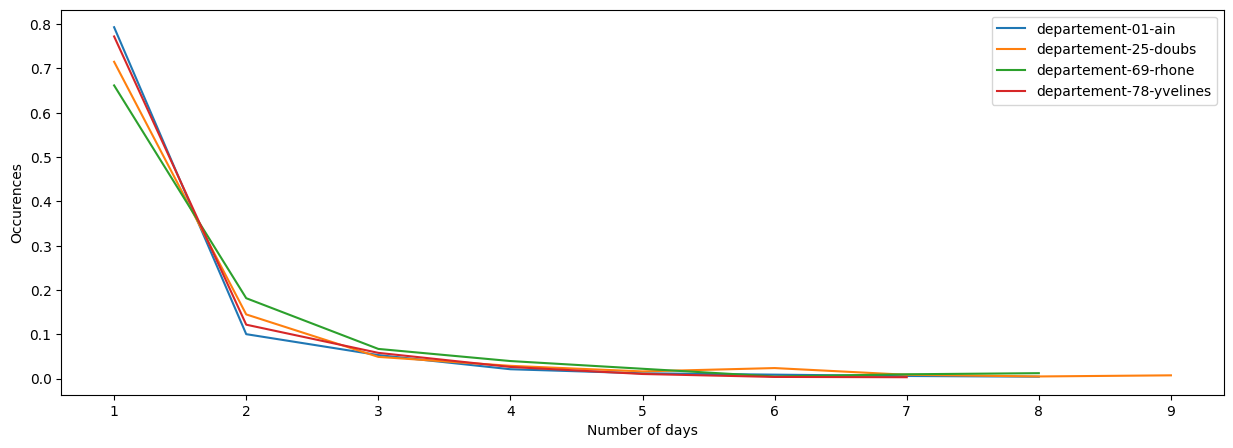

In [89]:
plt.figure(figsize=(15,5))
for dept in departement:
    y, x = np.histogram(sequences[dept]['ndays'], bins=np.unique(sequences[dept]['ndays']), density=True)
    print(y, x)
    plt.plot(x[:-1],y, label=dept)

plt.xlabel('Number of days')
plt.ylabel('Occurences')
plt.legend()

1.0
[1. 1. 1. 1. 1. 1. 1. 2. 3.]
1.0
[1. 1. 1. 1. 1. 1. 1. 2. 3.]
1.0
[1. 1. 1. 1. 1. 1. 2. 2. 3.]
1.0
[1. 1. 1. 1. 1. 1. 1. 2. 3.]


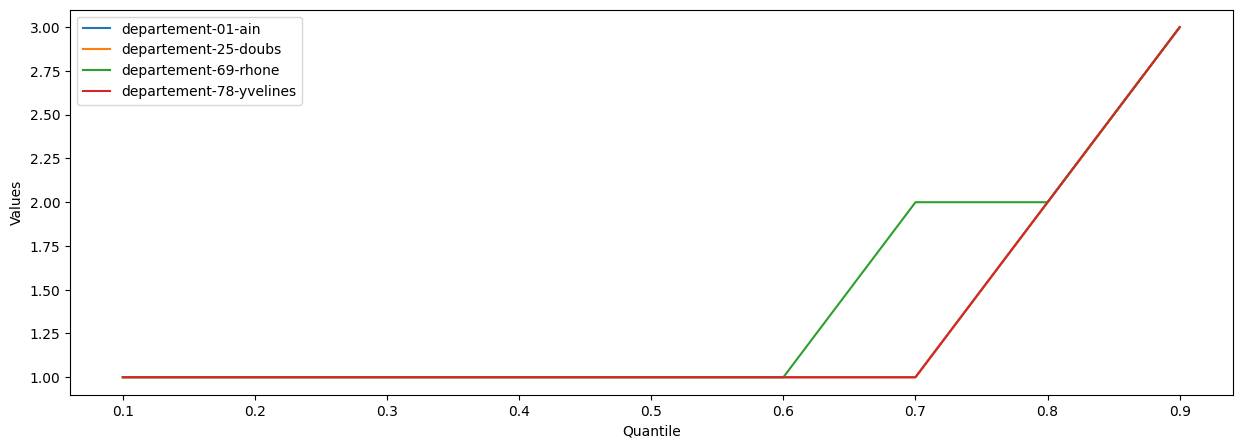

In [90]:
plt.figure(figsize=(15,5))
for dept in departement:
    x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    print(np.median(sequences[dept]['ndays']))
    print(np.quantile(sequences[dept]['ndays'], x))
    plt.plot(x, np.quantile(sequences[dept]['ndays'], x), label=dept)

plt.xlabel('Quantile')
plt.ylabel('Values')
plt.legend()
plt.show()

In [91]:
for dept in departement:
    print(dept, round(np.nanmean(sequences[dept]['seq'])))

departement-01-ain 4
departement-25-doubs 2
departement-69-rhone 2
departement-78-yvelines 3


### Spatial

In [92]:
def haversine(p1, p2, unit = 'kilometer'):
    import math
    # Coordinates in decimal degrees (e.g. 2.89078, 12.79797)
    lon1 = p1[0]
    lat1 = p1[1]
    lon2 = p2[0]
    lat2 = p2[1]

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    km = meters / 1000.0  # output distance in kilometers
    
    meters = round(meters)
    km = round(km, 3)

    if unit == 'kilometer':
        return km
    elif unit == 'meters':
        return meters
    else:
        return math.inf

In [93]:
import datetime as dt

def find_fire(center, newcenters, dt):
    newcenters = newcenters[(newcenters != center)]
    count = 1
    seen_nc = [center]
    for nc in newcenters:
        dist = haversine((float(center.x), float(center.y)), (float(nc.x), float(nc.y)))
        if dist <= dt:
            count += 1
            c, s = find_fire(nc, newcenters[(newcenters != nc) & (newcenters != center)], dt)
            count = max(count, c)
            seen_nc += s
            
    return count, seen_nc

for dept in departement:
    fpp = fp[fp['departement'] == dept]
    temp = fpp.groupby('date')['coef'].sum().reset_index()
    date_more_than_one_fire = temp[temp['coef'] > 1].date
    naturels_simpler_high = fpp[fpp['date'].isin(date_more_than_one_fire)]

    td = 10
    fpp['coef'] = 1

    uniqueDate = naturels_simpler_high.date.unique()

    sequence = []
    maxCount = 1
    biggest_sequence_day = None
    dist = []
    for ud in uniqueDate:
        t1 = dt.datetime.strptime(ud, '%Y-%m-%d') - dt.timedelta(days=np.mean(sequences[dept]['seq']))
        t2 = dt.datetime.strptime(ud, '%Y-%m-%d') + dt.timedelta(days=np.mean(sequences[dept]['seq']))
        naturelDate = naturels_simpler_high[(naturels_simpler_high['date'] <= t2.strftime('%Y-%m-%d')) & \
                                            (naturels_simpler_high['date'] >= t1.strftime('%Y-%m-%d'))]
        temp = naturelDate.groupby('centroid')['coef'].sum().reset_index()
        if len(temp) == 1:
            continue
        
        seen_nc = []
        """for ind, row in temp.iterrows():
            if row['centroid'] not in seen_nc:
                count, seen_nc = find_fire(row['centroid'], temp.centroid, td)
                if count > maxCount:
                    maxCount = count
                    biggest_sequence_day = ud
                sequence.append(count)"""

        seen_edge = []
        for ind, row in temp.iterrows():
            closestDist = []
            for ind2, row2 in temp.iterrows():
                if ind == ind2:
                    continue
                hav = haversine((float(row['centroid'].x), float(row['centroid'].y)), (float(row2['centroid'].x), float(row2['centroid'].y)))
                if hav < td:
                    closestDist.append(hav)
            if closestDist == []:
                continue
            dist.append(np.mean(closestDist))

    sequences[dept]['dist'] = dist
    sequences[dept]['seq'] = sequence

    print(np.unique(sequence)), biggest_sequence_day

/tmp/ipykernel_324356/1037543798.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpp['coef'] = 1


[]


/tmp/ipykernel_324356/1037543798.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpp['coef'] = 1


[]


/tmp/ipykernel_324356/1037543798.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpp['coef'] = 1


[]


/tmp/ipykernel_324356/1037543798.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpp['coef'] = 1


[]


In [94]:
for dept in departement:
    sequences[dept]['dist'] = [d // 2.2 for d in sequences[dept]['dist']]

[1305 2268 2127] [1. 2. 3. 4.]
[ 830 1941 1326] [1. 2. 3. 4.]
[186 262 214] [1. 2. 3. 4.]
[ 886 4265 2738] [1. 2. 3. 4.]


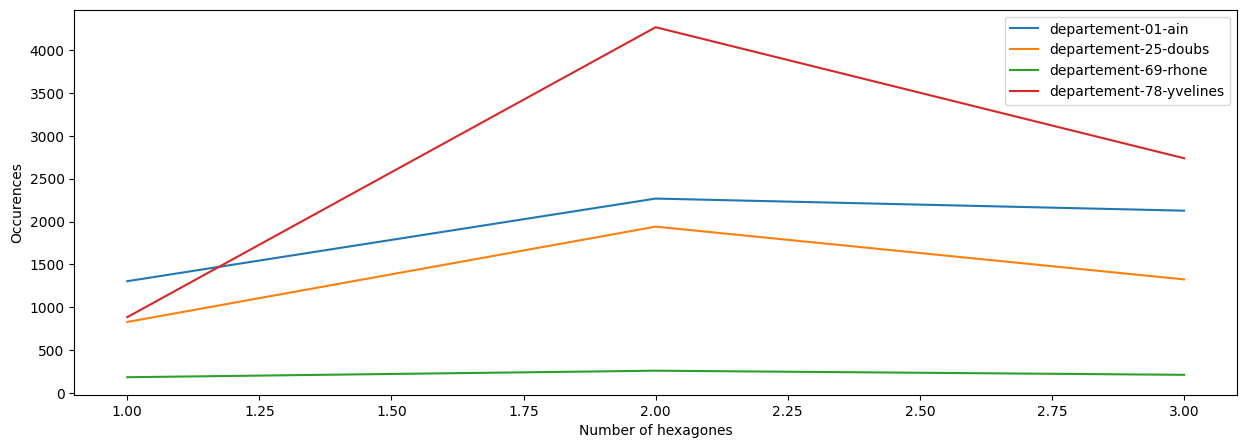

In [95]:
plt.figure(figsize=(15,5))
for dept in departement:
    y, x = np.histogram(sequences[dept]['dist'], bins=np.unique(sequences[dept]['dist']))
    print(y, x)
    plt.plot(x[:-1],y, label=dept)

plt.xlabel('Number of hexagones')
plt.ylabel('Occurences')
plt.legend()

2.0
[1. 1. 2. 2. 2. 2. 3. 3. 3.]
2.215263157894737
2.0
[1. 1. 2. 2. 2. 2. 3. 3. 3.]
2.179887722723944
2.0
[1. 1. 2. 2. 2. 2. 3. 3. 3.]
2.1253776435045317
2.0
[1. 2. 2. 2. 2. 2. 3. 3. 3.]
2.2706299911268855


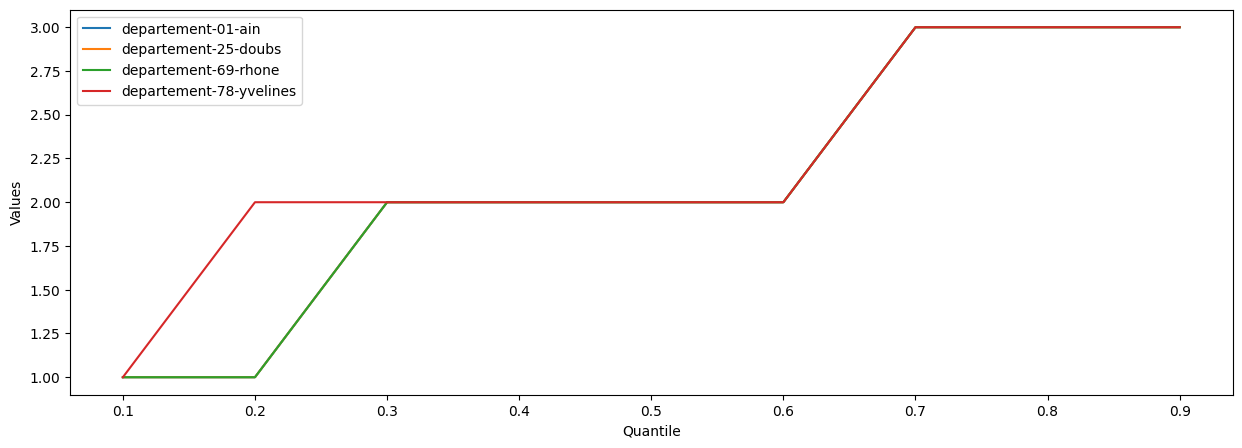

In [96]:
plt.figure(figsize=(15,5))
for dept in departement:
    x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    print(np.median(sequences[dept]['dist']))
    print(np.quantile(sequences[dept]['dist'], x))
    print(np.mean(sequences[dept]['dist']))
    plt.plot(x, np.quantile(sequences[dept]['dist'], x), label=dept)

plt.xlabel('Quantile')
plt.ylabel('Values')
plt.legend()
plt.show()

In [97]:
for dept in departement:
    print(dept, (np.mean(sequences[dept]['seq'])), np.max(sequences[dept]['seq']), np.min(sequences[dept]['seq']), np.median(sequences[dept]['seq']))

/home/caron/Bureau/.conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/caron/Bureau/.conda/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity